In [1]:
import pandas as pd
from collections import Counter
import requests
from typing import Dict, Tuple,List
import matplotlib.pyplot as plt
import os

In [2]:
tokenFile='token.ini'
dirData='data'

In [3]:
# Converts params from human-readable tuple into url request form
def setParams(searchCriteria: Tuple,maxRows: int=None):
    searchCriteria=searchCriteria
    params=[('fq',q) for q in searchCriteria]
    params[0]=('q',params[0][1])
    if maxRows:
        rows=[('rows',str(int(maxRows)))]
    else:
        rows=[('rows',str(int(2000)))]
    params=tuple(params+rows)
    return params

In [4]:
# Parameters for requests. The token can be obtained via Ads Settings->API Token
with open(tokenFile) as f:
    token = str(f.readline()).rstrip()
AdsUrl='https://api.adsabs.harvard.edu/v1/search/query'
headers = {'Authorization': 'Bearer '+token}

In [5]:
# Creating a request that returns number of publications in a given year
def request(year: int, additional:str='', propertyField: str='',doctypeField:str='')->int:
    searchCriteria=('year:'+str(year),'database:astronomy')
    if propertyField!='':
        if propertyField not in ('refereed','notrefereed'):
            raise ValueError()
        else:
            searchCriteria=searchCriteria+('property:'+propertyField,)
    if doctypeField!='':
        if doctypeField not in ('article','eprint','inproceedings','abstract','catalog'):
            raise ValueError()
        else:
            searchCriteria=searchCriteria+('doctype:'+doctypeField,)
    if additional!='':
        searchCriteria=searchCriteria+(additional,)
    
    params=setParams(searchCriteria,maxRows=10)
    response = requests.get(url=AdsUrl, headers=headers, params=params)
    count=response.json()['response']['numFound']
    return count

In [6]:
years=range(2000,2021)
statByYears=pd.DataFrame(columns=['year','ML refereed', 'ML non refereed', 'all refereed', 'all non refereed'])
for year in years:
    print(year)
    counts={'year':year}
    c=request(year,propertyField='refereed',additional='abs:"machine learning"')
    counts['ML refereed']=c
    c=request(year,propertyField='notrefereed',additional='abs:"machine learning"')
    counts['ML non refereed']=c
    c=request(year,propertyField='refereed')
    counts['all refereed']=c
    c=request(year,propertyField='notrefereed')
    counts['all non refereed']=c
    statByYears=statByYears.append(counts,ignore_index=True)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [7]:
statByYears

,year,ML refereed,ML non refereed,all refereed,all non refereed
0,2000,0,2,20006,28963
1,2001,2,7,19993,32548
2,2002,0,6,20510,33381
3,2003,0,6,22275,35031
4,2004,6,7,22340,38326
5,2005,4,11,24839,38281
6,2006,7,8,25710,41629
7,2007,13,7,23828,36330
8,2008,10,26,26725,41904
9,2009,12,21,28165,36404


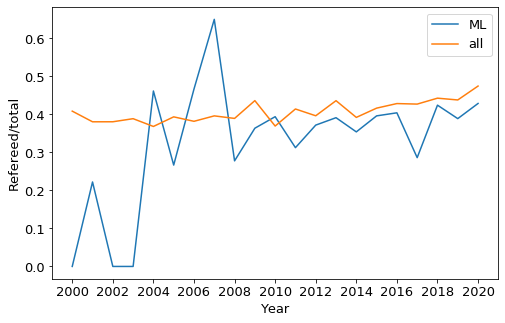

In [8]:
plt.rcParams.update({'font.size': 13})
fig,axs=plt.subplots(1,1,figsize=(8,5))
axs.plot(statByYears['year'],
         statByYears['ML refereed']/(statByYears['ML refereed']+statByYears['ML non refereed']),
         label="ML")
axs.plot(statByYears['year'],
         statByYears['all refereed']/(statByYears['all refereed']+statByYears['all non refereed']),
         label="all")

axs.xaxis.set_ticks(range(statByYears.iloc[0]['year'], statByYears.iloc[-1]['year']+2, 2))
axs.set_xlabel('Year')
axs.set_ylabel('Refereed/total')
axs.legend()

In [10]:
statByYears.to_csv(os.path.join(dirData,'refVsNonRef.csv'),index=False)